<a href="https://colab.research.google.com/github/abdulmalikajibadecodes/PdM/blob/main/PREDICTIVE_MAINTENANCE_CLASSIFICATION_PROJECT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Equipment Failure Type Classification for Predictive Maintenance <br> **By: Abdulmalik Ajibade**

Detecting failure types entails automatically identifying the specific types of equipment failures before the machine or equipment experiences a breakdown, aiming to prevent downtime. In this project, I built a classifier with a cost sensitive approach.

Data Source: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?resource=download


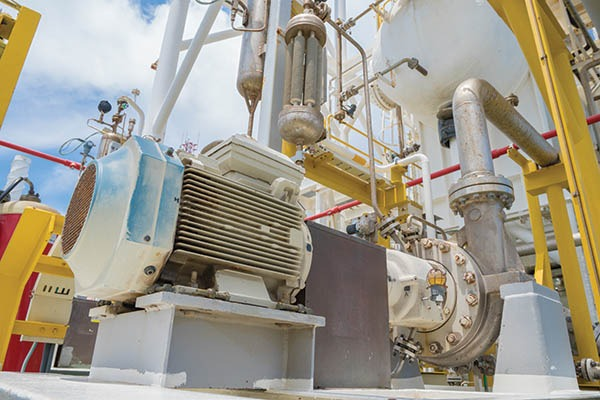

In [7]:
pip install -U scikit-plot

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import f1_score,fbeta_score,matthews_corrcoef, log_loss, confusion_matrix,classification_report,make_scorer,balanced_accuracy_score
from sklearn.metrics import (accuracy_score, roc_curve, auc,recall_score,roc_auc_score, average_precision_score,
                             precision_score,precision_recall_curve,ConfusionMatrixDisplay, confusion_matrix)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import multilabel_confusion_matrix
import scikitplot as skplt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (OneHotEncoder, PowerTransformer, StandardScaler)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

In [14]:
df = pd.read_csv('/content/predictive_maintenance.csv')

The dataset consists of 10 000 data points stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.


- Target : Failure or Not
- Failure Type : Type of Failure

In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


No null values

Predicting the failure type is the goal of this project. Let's see the class distribution of these failure types

In [ ]:
df['Failure Type'].value_counts() * 100 / df.shape[0]

No Failure                  96.52
Heat Dissipation Failure     1.12
Power Failure                0.95
Overstrain Failure           0.78
Tool Wear Failure            0.45
Random Failures              0.18
Name: Failure Type, dtype: float64

The class distribution are highly imbalanced with 'No Failure' failure type having more than 95% of the entire class instances in the dataset

<Axes: xlabel='count', ylabel='Failure Type'>

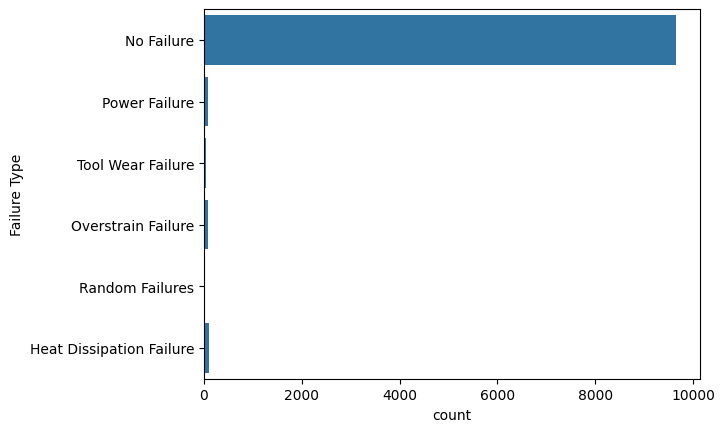

In [ ]:
sns.countplot(df['Failure Type'])

Features to drop:

In [ ]:
df.drop(['Product ID',"UDI","Target","Type"],axis=1, inplace=True)

"Target" feature was dropped because the aim is to predict the failure type not just whether a failure has will occure or not

In [ ]:
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,298.1,308.6,1551,42.8,0,No Failure
1,298.2,308.7,1408,46.3,3,No Failure
2,298.1,308.5,1498,49.4,5,No Failure
3,298.2,308.6,1433,39.5,7,No Failure
4,298.2,308.7,1408,40.0,9,No Failure


<Axes: >

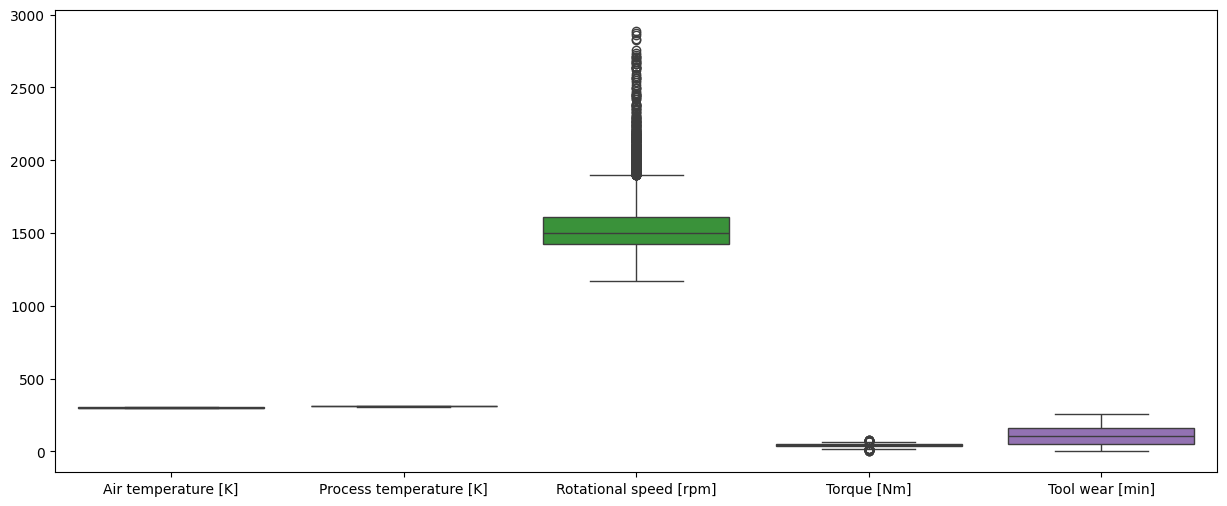

In [ ]:
# searching for outliers

plt.figure(figsize=(15,6))
sns.boxplot(data=df)


Are rotational speed outliers legit or not ?

checking the correlation of the different features:

In [ ]:
corr=df.iloc[:,:-1].corr()
corr

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000


Visualizing with heatmap:

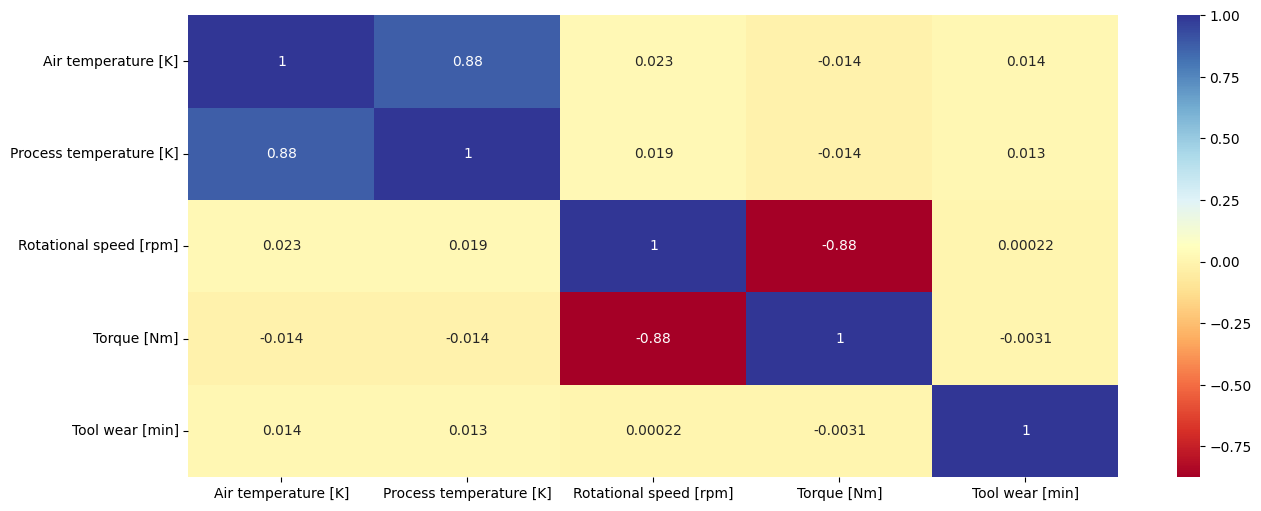

In [ ]:
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot=True,cmap = "RdYlBu")
plt.draw()

Many ML models require the features to be standardized first before passing it, apart from tree models. Let's visualise the distribution of each of these features to decide on standardization

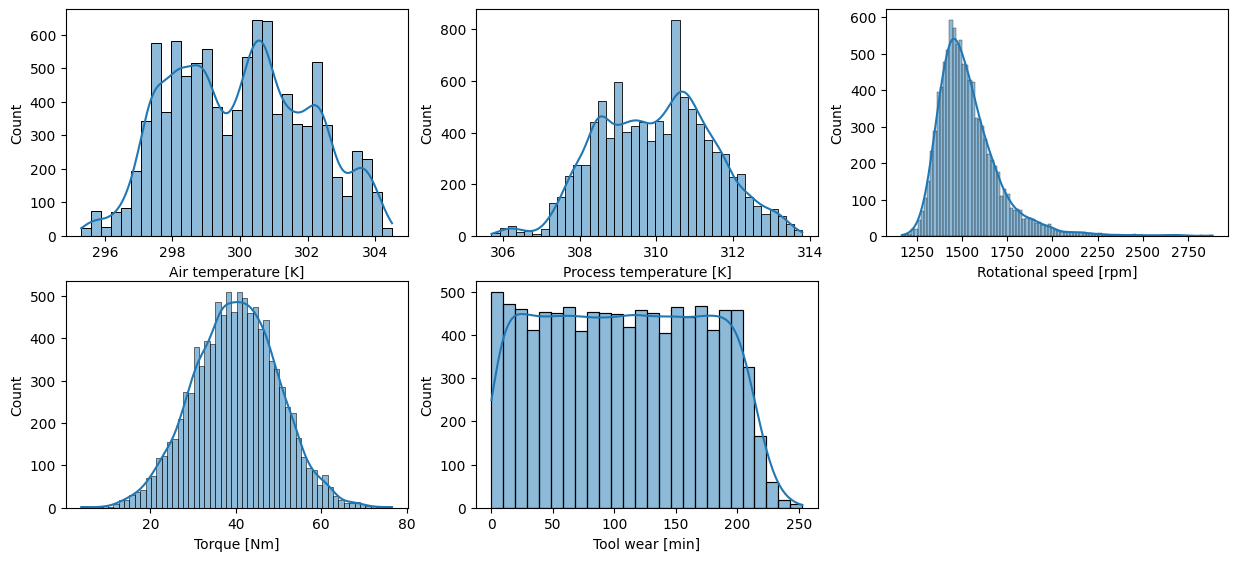

In [ ]:

plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns[:-1],1):
    plt.subplot(3,3,i)
    sns.histplot(df[col],kde=True)

A quick one! The rightly skewed ditribution of the rotational speed's feature explains the outliers visualized in the box plot. These data points should be kept and are legit


Different distribution behaviours observed:



1.   Features; "Air Temperature", "Process Temperature" and "Torque" all have near gaussian/normal distribution. These features will be transformed using normalization technique
2.   "Rotational speed" is skewed towards the right. An appropraite scaling would be the "box-cox" transformation
3. The tool wear feature shows a near uniform distribution. It is most appropraite to be scaled using MinMax scaling technique



Visualising the distribution of failure types in the relationship of highly correlated parameters. This will help understand how failure types in the minority class are distributed

In [ ]:
corr

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000


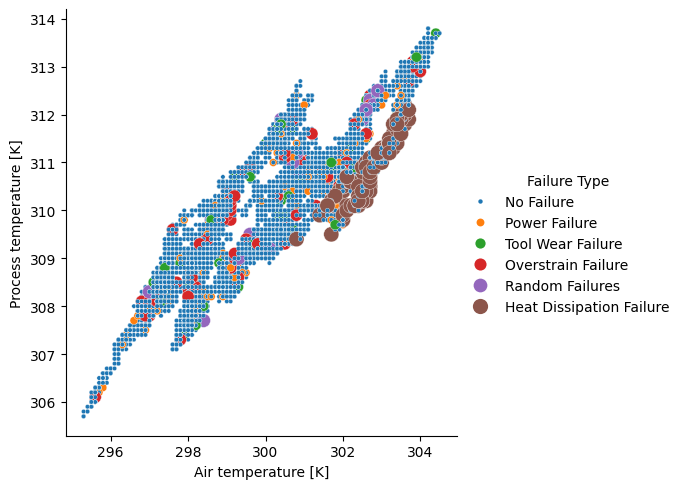

In [ ]:
sns.relplot(x="Air temperature [K]",
            y="Process temperature [K]",
            hue="Failure Type",
            size="Failure Type",
            sizes =(120,10), data=df)

Heat dissipation failures prominent with high process and high air temperature

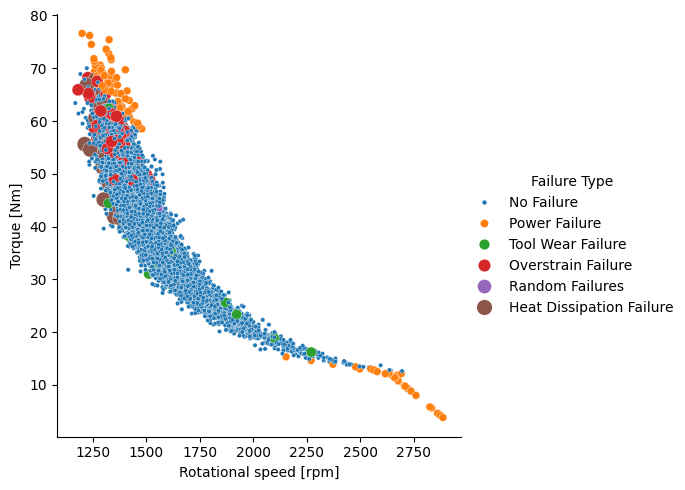

In [ ]:
sns.relplot(x="Rotational speed [rpm]",
            y="Torque [Nm]",
            hue="Failure Type",
            size="Failure Type",
            sizes =(120,10), data=df)

"Power Failure" and "Overstrain Failure" most prominent when their is high torque and relatively low rpm.<br>
"Power failure" is also largely associated with high rpm and low torque

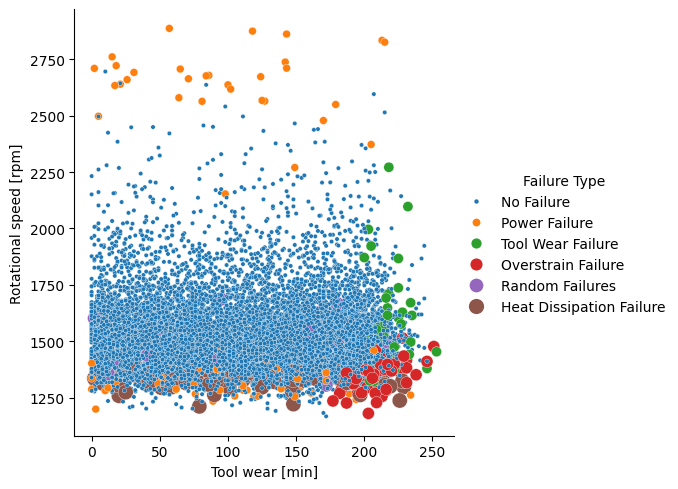

In [ ]:
sns.relplot(x="Tool wear [min]",
            y="Rotational speed [rpm]",
            hue="Failure Type",
            size="Failure Type",
            sizes =(120,10), data=df)

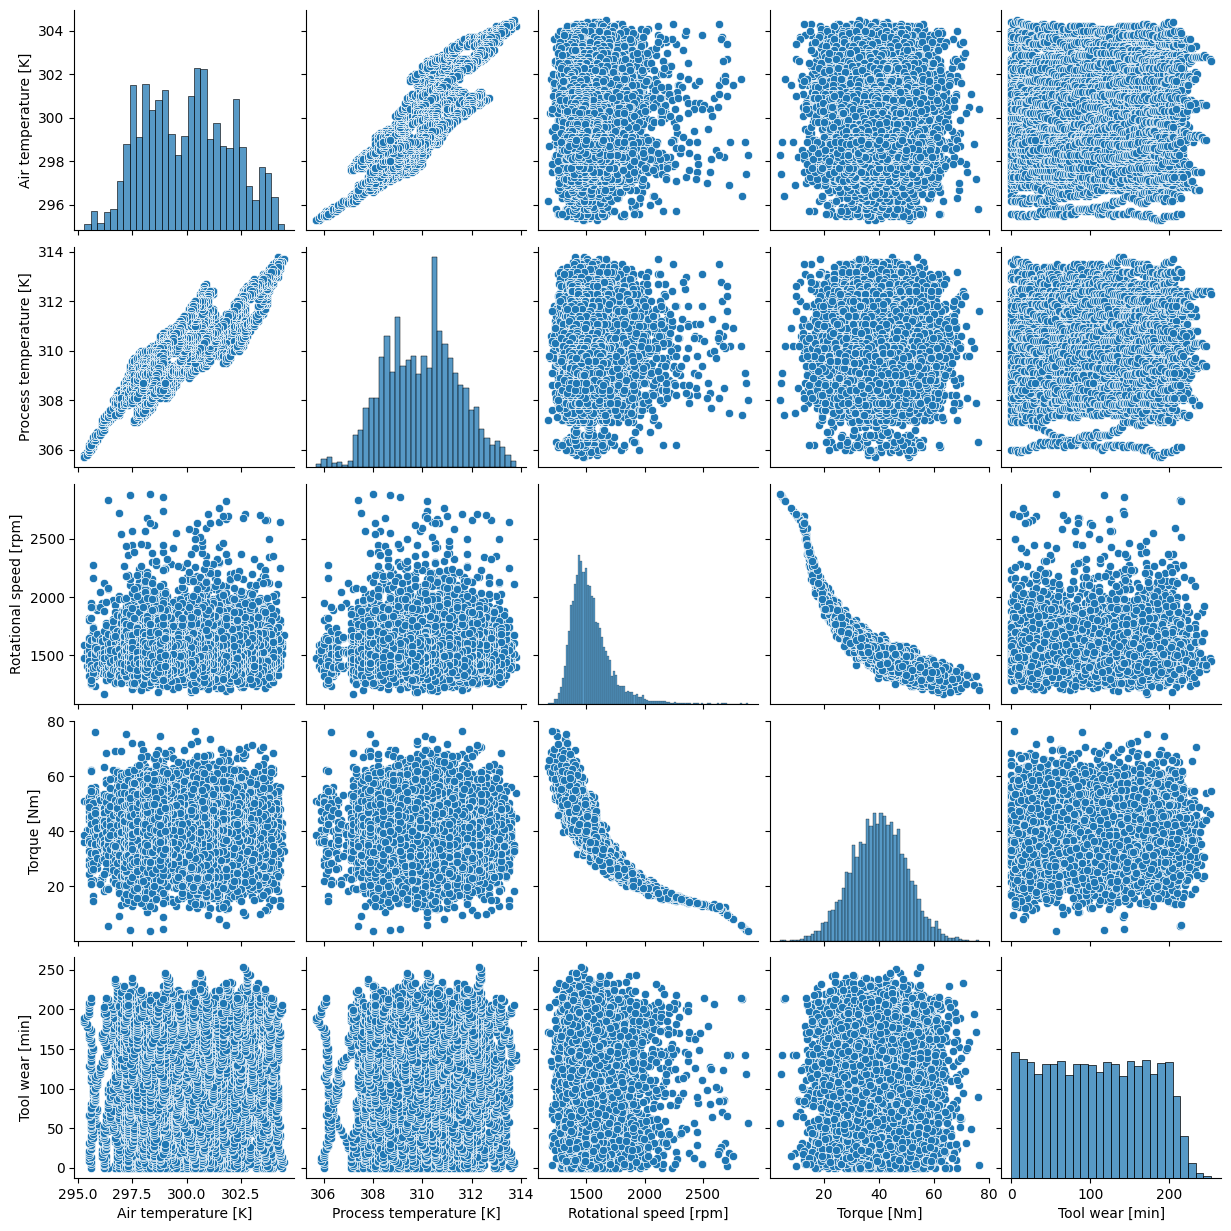

In [ ]:
#summary of feature relationship

sns.pairplot(df.select_dtypes(include=['int64', 'float64']))

Converting "Failure Type" classes to numerical labels:

In [ ]:
mapping = {'No Failure': 0, "Heat Dissipation Failure":1,"Power Failure": 2,"Overstrain Failure":3,"Tool Wear Failure":4,
          "Random Failures":5}

In [ ]:
df["Failure Type"].replace(mapping, inplace=True)

In [ ]:
X = df.copy()
y = X.pop("Failure Type")

Splitting data into training and testing data

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=30, test_size=0.3, stratify=y)

Using SMOTETomek class to populate synthetic data for imbalance minority classes. This would help prevent bias to the majority class

In [ ]:
from imblearn.combine._smote_tomek import SMOTETomek
smote = SMOTETomek(random_state=42)

In [ ]:
X1_smote, y1_smote = smote.fit_resample(X_train, y_train)

In [ ]:
list(zip(mapping,y1_smote.value_counts()))

[('No Failure', 6756),
 ('Heat Dissipation Failure', 6752),
 ('Power Failure', 6750),
 ('Overstrain Failure', 6748),
 ('Tool Wear Failure', 6742),
 ('Random Failures', 6724)]

Text(0.5, 0, 'Failure Type')

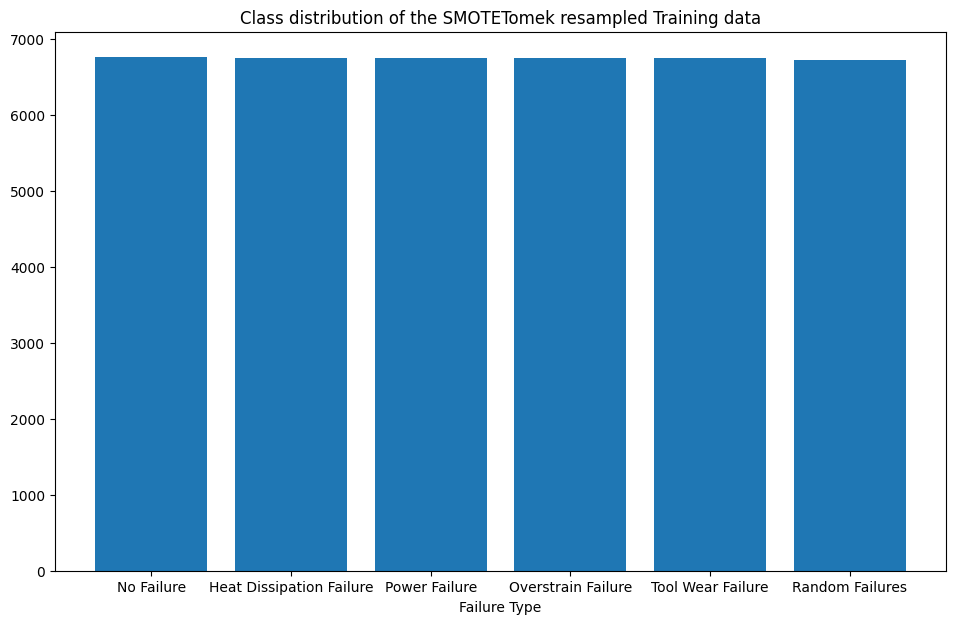

In [ ]:
plt.figure(figsize=(11.5,7))
plt.bar(mapping.keys(),y1_smote.value_counts())
plt.title("Class distribution of the SMOTETomek resampled Training data")
plt.xlabel("Failure Type")


Classes in the target variable are now balanced

### Preprocessing

Different distribution behaviours observed:



1.   Features; "Air Temperature", "Process Temperature" and "Torque" all have near gaussian/normal distribution. These features will be transformed using normalization technique
2.   "Rotational speed" is skewed towards the right. An appropraite scaling would be the "box-cox" transformation
3. The tool wear feature shows a near uniform distribution. It is most appropraite to be scaled using MinMax scaling technique


In [ ]:
X_train.columns


Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [ ]:
standard_scale_col = ["Air temperature [K]", 'Process temperature [K]','Torque [Nm]' ]
power_scale_col = ['Rotational speed [rpm]']
minmax_scale_col = ["Tool wear [min]"]


#make preprocessing pipes

pipe1 = make_pipeline(StandardScaler())
pipe2 = make_pipeline(PowerTransformer())
pipe3 = make_pipeline(MinMaxScaler())


# Full preprocessing pipeline

preprocess_pipeline = ColumnTransformer(
    transformers=[("standardization", pipe1, standard_scale_col),
                  ("power_transform", pipe2, power_scale_col),
                  ("minmax", pipe3, minmax_scale_col)]
)


### Random Forest

In [ ]:
rfc = OutputCodeClassifier(RandomForestClassifier(), code_size=6, random_state=40)

rfc_pipeline = Pipeline(
    steps=[("preprocessing", preprocess_pipeline), ("random_forest", rfc)]
)

In [ ]:
rfc_model = rfc_pipeline.fit(X1_smote, y1_smote)

y_pred_rfc = rfc_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2896
           1       0.31      0.50      0.39        34
           2       0.33      0.71      0.45        28
           3       0.54      0.87      0.67        23
           4       0.04      0.14      0.06        14
           5       0.04      0.20      0.06         5

    accuracy                           0.93      3000
   macro avg       0.37      0.56      0.43      3000
weighted avg       0.97      0.93      0.95      3000



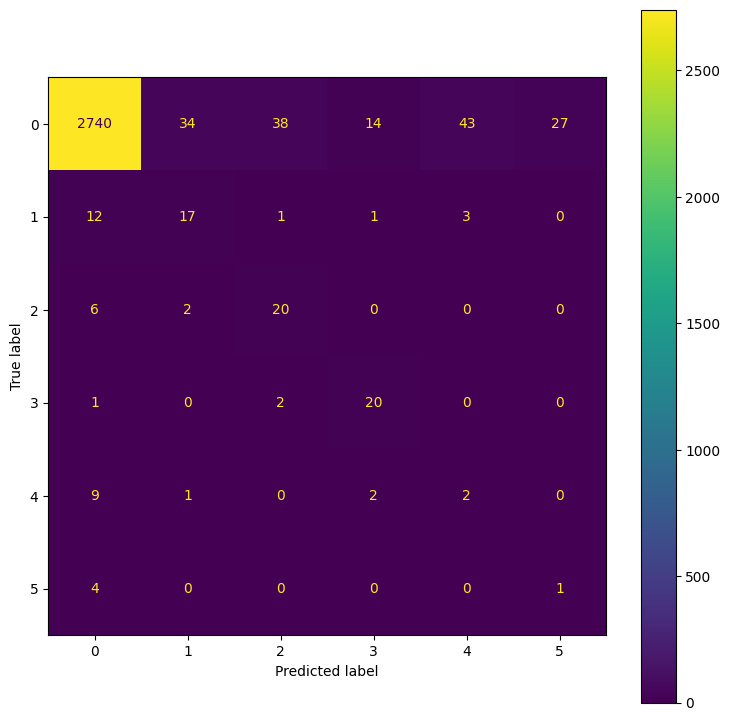

In [ ]:
def plot_confusion_matrix(y_pred):
  fig, ax = plt.subplots(figsize=(9, 9))
  print(classification_report(y_test, y_pred))
  # Create the matrix
  cm = confusion_matrix(y_test, y_pred)
  cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_pipeline.classes_)
  cmp.plot(ax=ax)
  plt.show();


plot_confusion_matrix(y_pred_rfc)

In [ ]:
def print_scores(y_pred):
  print("Accuracy Score: %.4f" %(accuracy_score(y_test,y_pred)))
  print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test,y_pred)))


print_scores(y_pred_rfc)

Accuracy Score: 0.9333
Matthews correlation coefficient: 0.4113


### LGBM

In [ ]:
lgbm = OutputCodeClassifier(LGBMClassifier(), code_size=6, random_state=30)

lgbm_pipeline = Pipeline(
    steps=[("preprocessing", preprocess_pipeline), ("LGBM", lgbm)]
)

lgbm_model = lgbm_pipeline.fit(X1_smote, y1_smote)

y_pred_lgbm = lgbm_model.predict(X_test)

[LightGBM] [Info] Number of positive: 20214, number of negative: 20258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 40472, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499456 -> initscore=-0.002174
[LightGBM] [Info] Start training from score -0.002174
[LightGBM] [Info] Number of positive: 13494, number of negative: 26978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 40472, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333416 -> initscore=-0.692777
[LightGBM] [Info] Start training from score -0.692777
[LightGBM] [In

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2896
           1       0.61      0.79      0.69        34
           2       0.66      0.89      0.76        28
           3       0.51      0.96      0.67        23
           4       0.02      0.07      0.03        14
           5       0.01      0.20      0.02         5

    accuracy                           0.92      3000
   macro avg       0.47      0.64      0.52      3000
weighted avg       0.97      0.92      0.95      3000



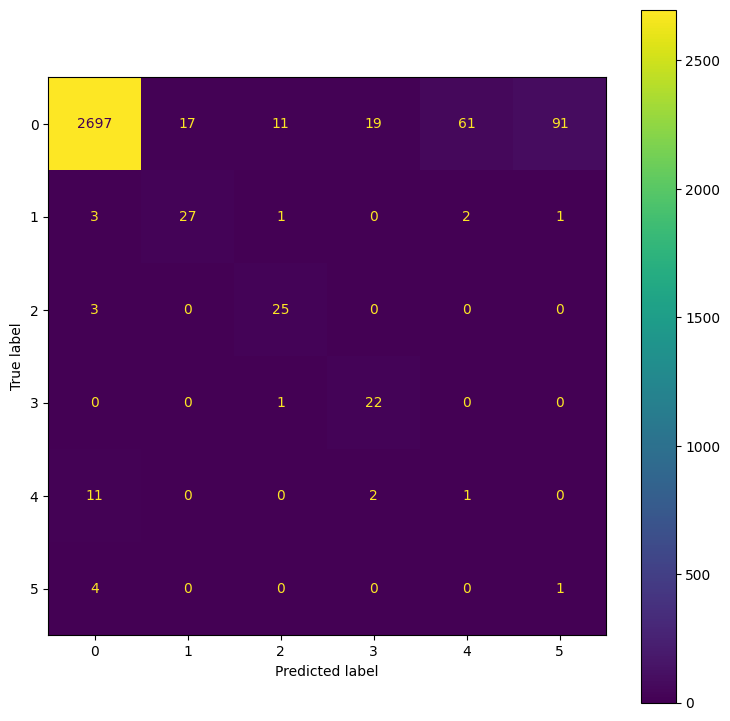

In [ ]:
plot_confusion_matrix(y_pred_lgbm)

In [ ]:
print_scores(y_pred_lgbm)

Accuracy Score: 0.9243
Matthews correlation coefficient: 0.4488


## XGBOOST

In [ ]:
xgb = OutputCodeClassifier(XGBClassifier(), code_size= 6 , random_state=30)

xgb_pipeline = Pipeline(
    steps=[("preprocessing", preprocess_pipeline), ("XGB", xgb)]
)

In [ ]:
xgb_model = xgb_pipeline.fit(X1_smote, y1_smote)

y_pred_xgb = xgb_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2896
           1       0.66      0.79      0.72        34
           2       0.66      0.89      0.76        28
           3       0.55      0.91      0.69        23
           4       0.02      0.07      0.03        14
           5       0.00      0.00      0.00         5

    accuracy                           0.95      3000
   macro avg       0.48      0.60      0.53      3000
weighted avg       0.98      0.95      0.96      3000



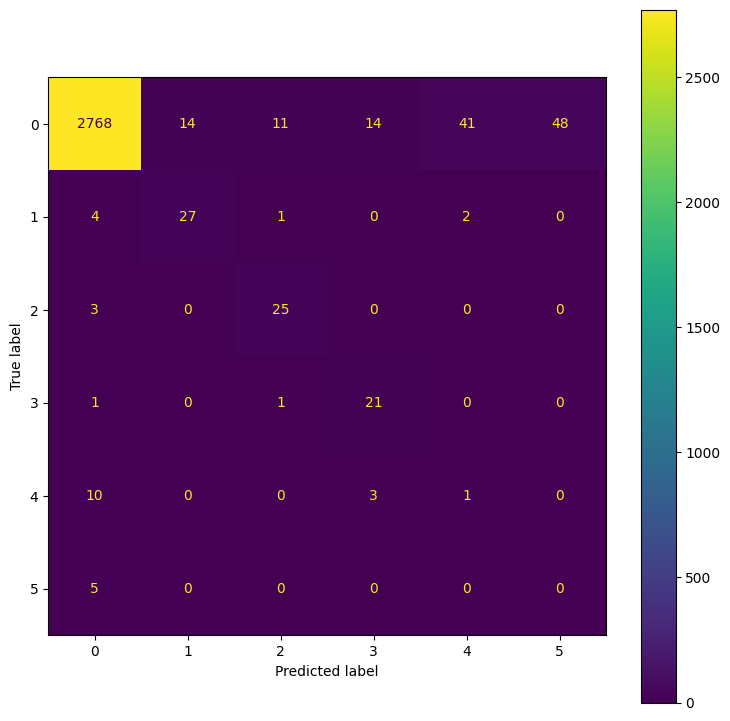

In [ ]:
plot_confusion_matrix(y_pred_xgb)

In [ ]:
print_scores(y_pred_xgb)

Accuracy Score: 0.9473
Matthews correlation coefficient: 0.5127


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool, cv

In [ ]:
catb = OutputCodeClassifier(CatBoostClassifier(random_seed=30,logging_level='Silent'), code_size=6, random_state=30)

catb_pipeline = Pipeline(
    steps=[("preprocessing", preprocess_pipeline), ("CatBoost", catb)]
)

catb_model = catb_pipeline.fit(X1_smote, y1_smote)

y_pred_catb = catb_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2896
           1       0.64      0.85      0.73        34
           2       0.66      0.89      0.76        28
           3       0.51      0.87      0.65        23
           4       0.06      0.21      0.10        14
           5       0.00      0.00      0.00         5

    accuracy                           0.95      3000
   macro avg       0.48      0.63      0.53      3000
weighted avg       0.98      0.95      0.96      3000



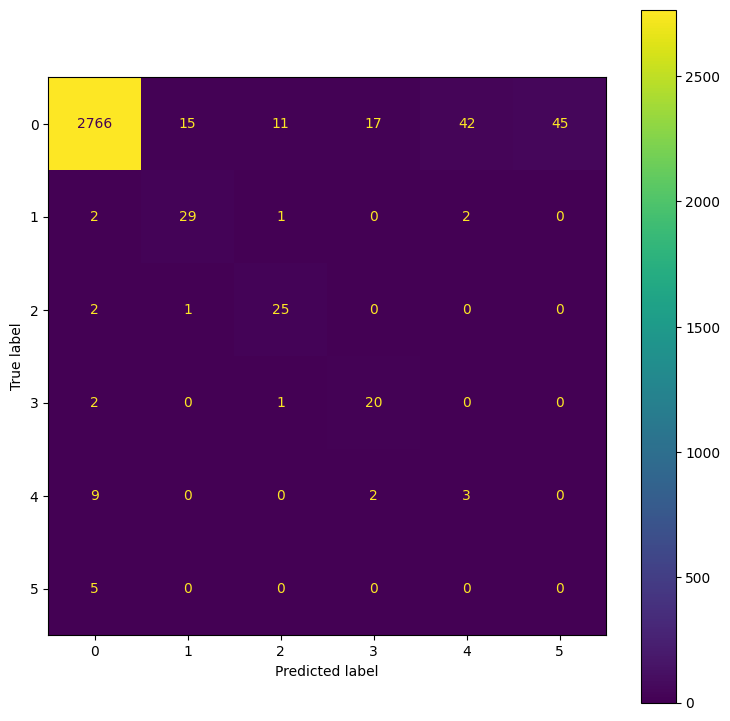

In [ ]:
plot_confusion_matrix(y_pred_catb)

In [ ]:
print_scores(y_pred_catb)

Accuracy Score: 0.9477
Matthews correlation coefficient: 0.5269


## Model Selection

Prior to deployment, the critical step is to carefully choose the optimal model. Relying solely on the accuracy score might not provide sufficient insights in this scenario, primarily due to the presence of class imbalance. Additionally, it is crucial to take into account the cost implications associated with the model predictions. Conducting a cost analysis, derived from the model's performance outlined in the confusion matrix, will significantly contribute to this decision-making process.

The optimal scenario involves a model capturing as much failure as possible, even if it results in occasional false alerts when there is, in fact, no failure. This preference arises from the severe consequences of not identifying a failure, potentially leading to equipment damage.

Therefore, the most effective model would demonstrate a higher recall, minimizing false negatives, particularly for various failure types, excluding 'No Failure.'

For the 'No Failure' category, the goal is for the model to make more accurate predictions than misclassifying actual failures as 'No Failures.' The primary objective remains to capture as many actual failures as feasible, making higher precision desirable for the 'No Failure' type, effectively reducing false positives.

Given the substantial cost associated with a False Negative 'No Failure' prediction, leading to numerous unidentified failures due to misclassification, this metric serves as a pivotal factor in selecting the most cost-effective model. This evaluation occurs after comparing F1 and Accuracy scores.

In [ ]:
models_pred = {'Random Forest': y_pred_rfc, 'LGBM': y_pred_lgbm, 'XGBOOST': y_pred_xgb, 'Catboost': y_pred_catb}

In [ ]:
margin = "------------------------------------------------------------"

for model_name, model_pred in models_pred.items():
  print(model_name, "\n" , classification_report(y_test,model_pred),"\n", margin)
  print()

Random Forest 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      2896
           1       0.31      0.50      0.39        34
           2       0.33      0.71      0.45        28
           3       0.54      0.87      0.67        23
           4       0.04      0.14      0.06        14
           5       0.04      0.20      0.06         5

    accuracy                           0.93      3000
   macro avg       0.37      0.56      0.43      3000
weighted avg       0.97      0.93      0.95      3000
 
 ------------------------------------------------------------

LGBM 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      2896
           1       0.61      0.79      0.69        34
           2       0.66      0.89      0.76        28
           3       0.51      0.96      0.67        23
           4       0.02      0.07      0.03        14
           5       0.01      0.20      0.02  

Need to analyze based on FN

In [ ]:
scores={}

for model_name, model_pred in models_pred.items():
  scores[model_name]=round(accuracy_score(y_test, model_pred),3)


scores.items()

dict_items([('Random Forest', 0.933), ('LGBM', 0.924), ('XGBOOST', 0.947), ('Catboost', 0.948)])

All have similar accuracy score with CatBoost and XGBOOST Performing the best


In [ ]:
#making decision based on false negatives for the "No Failure" Failure type

fn_no_failure = {}

for model_name, model_pred in models_pred.items():
  conf=confusion_matrix(y_test, model_pred)
  fn_no_failure[model_name] = np.sum(conf[1:,0])



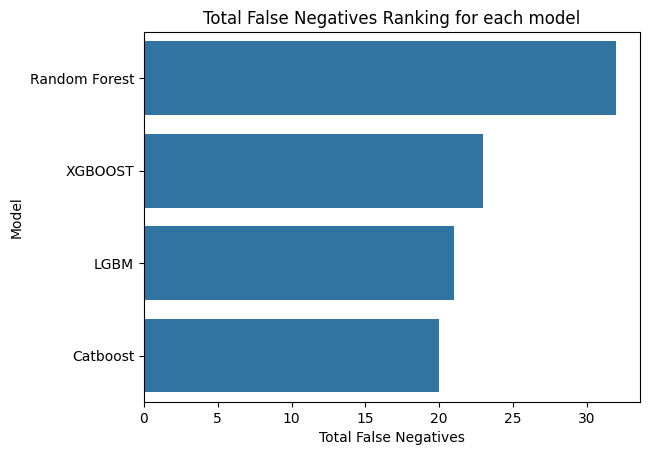

In [ ]:
check = pd.DataFrame({'FN_sums': fn_no_failure.values() },\
                     index=fn_no_failure.keys()).\
                     sort_values(by='FN_sums', ascending=False)



sns.barplot(x='FN_sums', y=check.index, orient='h', data=check)

plt.title('Total False Negatives Ranking for each model')
plt.ylabel('Model')
plt.xlabel('Total False Negatives')

plt.show()

CatBoost emerges as the most cost-effective model for deployment, boasting both the highest accuracy score and the lowest incidence of false negatives, particularly for the "No Failure" category.

# Conclusion:
In this predictive maintenance classification project, my primary goal was to develop a robust model for identifying equipment failure types before they occur, thereby minimizing downtime and potential damage. Several machine learning models, including Random Forest, LGBM, XGBOOST, and CatBoost, were employed and rigorously evaluated.

### Key Findings:

1. Data Insights:

*   The dataset, comprising 10,000 data points and 14 features, offered valuable insights into the dynamics of equipment failures.
*   Class distribution analysis revealed a highly imbalanced dataset, with the majority of instances belonging to the 'No Failure' class.



### Data Preprocessing:

* Imbalanced classes were addressed using the SMOTETomek resampling technique, ensuring a more equitable representation of failure types.

* Features were preprocessed through a combination of standardization, power transformation, and MinMax scaling based on their distribution characteristics.


### Model Evaluation:

* Four models, namely Random Forest, LGBM, XGBOOST, and CatBoost, were trained and evaluated for their performance.

* The evaluation metrics included accuracy scores, Matthews correlation coefficient, and confusion matrices, with a particular focus on false negatives for the 'No Failure' category.


### Model Selection:

* CatBoost emerged as the preferred model for deployment due to its superior accuracy score and minimal incidence of false negatives, especially for the critical 'No Failure' class.

* The decision-making process considered not only accuracy but also the potential cost implications associated with false negatives.

### Future Considerations:

* Hyperparameter Tuning:

Further optimization of model hyperparameters could potentially enhance model performance.

* Feature Engineering:

Exploring additional features or engineering existing ones may contribute to better predictive capabilities.

* Real-time Implementation:

Consideration of real-time implementation challenges and integration into an operational environment.

### Final Thoughts:
Choosing the right predictive maintenance model involves a delicate balance between accuracy and the ability to minimize false negatives. The CatBoost model, with its strong performance in both aspects, positions itself as a promising candidate for deployment in real-world scenarios. As technologies evolve and more data becomes available, ongoing refinement of the model will be essential for ensuring its continued effectiveness in predicting equipment failures.

